# Bike

In [1]:
import numpy as np
from numpy import sin,cos,pi,sqrt
np.set_printoptions(precision=7,suppress=True)
from numpy.linalg import inv
import matplotlib.pyplot as plt
import control as ct

In [415]:
class Bike():
    angle=0.01/180*pi
    g=9.81
    def __init__(self,w=1.02,c=0.08,lmd=pi/10,rR=0.3,mR=2,IRxx=0.0603,IRyy=0.12,xB=0.3,zB=-0.9,mB=85,IBxx=9.2,IBxz=2.4,IBzz=2.8,IByy=11,
                 xH=0.9,zH=-0.7,mH=4,IHxx=0.05892,IHxz=-0.00756,IHzz=0.00708,IHyy=0.06,rF=0.35,mF=3,IFxx=0.1405,IFyy=0.28):
        self.w=w
        self.c=c
        self.lmd=lmd
        self.rR=rR
        self.mR=mR
        self.IRxx=IRxx
        self.IRyy=IRyy
        self.IRzz=IRxx
        self.xB=xB
        self.zB=zB
        self.mB=mB
        self.IBxx=IBxx
        self.IBxz=IBxz
        self.IBzz=IBzz
        self.IByy=IByy
        self.xH=xH
        self.zH=zH
        self.mH=mH
        self.IHxx=IHxx
        self.IHxz=IHxz
        self.IHzz=IHzz
        self.IHyy=IHyy
        self.rF=rF
        self.mF=mF
        self.IFxx=IFxx
        self.IFyy=IFyy
        self.IFzz=IFxx
        self.mu=c/w*cos(lmd)
        self.mT=mR+mB+mH+mF
    # region linear model coefficient
    def K0(self):
        SA=-(self.mH*self.zH-self.mF*self.rF)*sin(self.lmd)+(self.mH*(self.xH-self.w-self.c)-self.mF*self.c)*cos(self.lmd)+self.c/self.w*cos(self.lmd)*(self.mB*self.xB+self.mH*self.xH+self.mF*self.w)
        K0=np.array([
            [-self.mR*self.rR+self.mB*self.zB+self.mH*self.zH-self.mF*self.rF,-SA],
            [-SA,-SA*sin(self.lmd)]
        ])
        return K0
    def M(self):
        muxSH=self.mu*self.xH+(cos(self.lmd)*(self.xH-self.w-self.c)-sin(self.lmd)*self.zH)
        muxSF=self.mu*self.w+(-cos(self.lmd)*self.c+sin(self.lmd)*self.rF)
        R_T=self.mR*np.array([
            [self.rR**2,0],
            [0,0]
        ]) 
        B_T=self.mB*np.array([
            [self.zB**2,-self.mu*self.xB*self.zB],
            [-self.mu*self.xB*self.zB,self.mu**2*self.xB**2]
        ])
        H_T=self.mH*np.array([
            [self.zH**2,-muxSH*self.zH],
            [-muxSH*self.zH,muxSH**2]
        ])
        F_T=self.mF*np.array([
            [self.rF**2,muxSF*self.rF],
            [muxSF*self.rF,muxSF**2]
        ])
        R_R=np.array([
            [self.IRxx,0],
            [0,self.mu**2*self.IRxx]
        ])
        B_R=np.array([
            [self.IBxx,self.mu*self.IBxz],
            [self.mu*self.IBxz,self.mu**2*self.IBzz]
        ])
        H_R=np.array([
            [self.IHxx,sin(self.lmd)*self.IHxx+(self.mu+cos(self.lmd))*self.IHxz],
            [sin(self.lmd)*self.IHxx+(self.mu+cos(self.lmd))*self.IHxz,(self.mu+cos(self.lmd))**2*self.IHzz+2*sin(self.lmd)*(self.mu+cos(self.lmd))*self.IHxz+sin(self.lmd)**2*self.IHxx]
        ])
        F_R=np.array([
            [self.IFxx,self.IFxx*sin(self.lmd)],
            [self.IFxx*sin(self.lmd),self.IFxx*((self.mu+cos(self.lmd))**2+sin(self.lmd)**2)]
        ])
        return R_T+B_T+H_T+F_T+R_R+B_R+H_R+F_R
    def C1(self):
        cH=(self.mu*self.xH+cos(self.lmd)*(self.xH-self.w-self.c)-sin(self.lmd)*self.zH)*(self.mu+cos(self.lmd)/self.w*self.xH)
        cF=(self.mu*self.w-cos(self.lmd)*self.c+sin(self.lmd)*self.rF)*(self.mu+cos(self.lmd))
        R_T=self.mR*np.array([
            [0,self.mu*self.rR],
            [0,0]
        ]) 
        B_T=self.mB*np.array([
            [0,-self.zB*(self.mu+cos(self.lmd)/self.w*self.xB)],
            [0,self.mu*self.xB*(self.mu+cos(self.lmd)/self.w*self.xB)]
        ])
        H_T=self.mH*np.array([
            [0,-self.zH*(self.mu+cos(self.lmd)/self.w*self.xH)],
            [0,cH]
        ])
        F_T=self.mF*np.array([
            [0,self.rF*(self.mu+cos(self.lmd))],
            [0,cF]
        ])
        R_R=np.array([
            [0,self.mu/self.rR*self.IRyy],
            [-self.mu/self.rR*self.IRyy,self.mu*cos(self.lmd)/self.w*self.IRxx]
        ])
        B_R=np.array([
            [0,cos(self.lmd)/self.w*self.IBxz],
            [0,self.mu*cos(self.lmd)/self.w*self.IBzz]
        ])
        H_R=np.array([
            [0,cos(self.lmd)/self.w*self.IHxz],
            [0,cos(self.lmd)/self.w*(sin(self.lmd)*self.IHxz+(self.mu+cos(self.lmd))*self.IHzz)]
        ])
        F_R=np.array([
            [0,(self.mu+cos(self.lmd))/self.rF*self.IFyy],
            [-(self.mu+cos(self.lmd))/self.rF*self.IFyy,cos(self.lmd)*(self.mu+cos(self.lmd))/self.w*self.IFxx]
        ])
        return R_T+B_T+H_T+F_T+R_R+B_R+H_R+F_R
    def K2(self):
        bH=cos(self.lmd)/self.w*(self.mu*self.xH+cos(self.lmd)*(self.xH-self.w-self.c)-sin(self.lmd)*self.zH)
        bF=cos(self.lmd)/self.w*(self.mu*self.w-cos(self.lmd)*self.c+sin(self.lmd)*self.rF)
        R_T=self.mR*np.array([
            [0,cos(self.lmd)/self.w*self.rR],
            [0,0]
        ])
        B_T=self.mB*np.array([
            [0,-cos(self.lmd)/self.w*self.zB],
            [0,cos(self.lmd)/self.w*self.mu*self.xB]
        ])
        H_T=self.mH*np.array([
            [0,-cos(self.lmd)/self.w*self.zH],
            [0,bH]
        ]) 
        F_T=self.mF*np.array([
            [0,cos(self.lmd)/self.w*self.rF],
            [0,bF]
        ]) 
        R_R=np.array([
            [0,1/self.rR*cos(self.lmd)/self.w*self.IRyy],
            [0,0]
        ]) 
        B_R=np.array([
            [0,0],
            [0,0]
        ]) 
        H_R=np.array([
            [0,0],
            [0,0]
        ]) 
        F_R=np.array([
            [0,1/self.rF*self.IFyy/self.w*cos(self.lmd)],
            [0,sin(self.lmd)/self.rF*cos(self.lmd)/self.w*self.IFyy]
        ])
        return R_T+B_T+H_T+F_T+R_R+B_R+H_R+F_R
    def Lit(self):
        mT=self.mR+self.mB+self.mH+self.mF
        if mT==0:
            xT=0
            zT=0
        else:
            xT=(self.mB*self.xB+self.mH*self.xH+self.mF*self.w)/mT
            zT=(-self.mR*self.rR+self.mB*self.zB+self.mH*self.zH-self.mF*self.rF)/mT
        mA=self.mH+self.mF
        if mA==0:
            xA=0
            zA=0
        else:
            xA=(self.mH*self.xH+self.mF*self.w)/mA
            zA=(self.mH*self.zH-self.mF*self.rF)/mA
        uA=(xA-self.w-self.c)*cos(self.lmd)-zA*sin(self.lmd)
        SA=mA*uA+self.mu*mT*xT
        SR=self.IRyy/self.rR
        SF=self.IFyy/self.rF
        ST=SR+SF
        ITxx=self.mR*self.rR**2+self.mB*self.zB**2+self.mH*self.zH**2+self.mF*self.rF**2+self.IRxx+self.IBxx+self.IHxx+self.IFxx
        ITzz=self.mB*self.xB**2+self.mH*self.xH**2+self.mF*self.w**2+self.IRzz+self.IBzz+self.IHzz+self.IFzz
        ITxz=-self.mB*self.xB*self.zB-self.mH*self.xH*self.zH+self.mF*self.rF*self.w+self.IBxz+self.IHxz
        IAxx=self.mH*(self.zH-zA)**2+self.mF*(self.rF+zA)**2+self.IHxx+self.IFxx
        IAzz=self.mH*(self.xH-xA)**2+self.mF*(self.w-xA)**2+self.IHzz+self.IFzz
        IAxz=-self.mH*(self.xH-xA)*(self.zH-zA)+self.mF*(self.w-xA)*(self.rF+zA)+self.IHxz
        IAll=mA*uA**2+IAxx*sin(self.lmd)**2+2*IAxz*sin(self.lmd)*cos(self.lmd)+IAzz*cos(self.lmd)**2
        IAlx=-mA*uA*zA+IAxx*sin(self.lmd)+IAxz*cos(self.lmd)
        IAlz=mA*uA*xA+IAxz*sin(self.lmd)+IAzz*cos(self.lmd)
        K0=np.array([
            [mT*zT,-SA],
            [-SA,-SA*sin(self.lmd)]
        ])
        K2=cos(self.lmd)/self.w*np.array([
            [0,ST-mT*zT],
            [0,SA+SF*sin(self.lmd)]
        ])
        C1=np.array([
            [0,self.mu*ST+SF*cos(self.lmd)+cos(self.lmd)/self.w*ITxz-self.mu*mT*zT],
            [-self.mu*ST-SF*cos(self.lmd),cos(self.lmd)/self.w*IAlz+self.mu*SA+self.mu*cos(self.lmd)/self.w*ITzz]
        ])
        M=np.array([
            [ITxx,IAlx+self.mu*ITxz],
            [IAlx+self.mu*ITxz,IAll+2*self.mu*IAlz+self.mu**2*ITzz]
        ])
        return M,K0,K2,C1
    def LinearMatrix(self,v):
        A=np.vstack((np.hstack((np.zeros((2,2)),np.identity(2))),np.hstack((-inv(self.M())@(self.g*self.K0()+v*v*self.K2()),-inv(self.M())@self.C1()*v))))
        B=np.vstack((np.zeros((2,1)),inv(self.M())@np.array([[0],[1]])))
        return A,B
    # endregion
    # region find thetaB and thetaU
    def Zero(self,phi,thetaB,delta,thetaU):
        Zero=(
        -self.rR*cos(phi)-self.c*cos(self.lmd)*sin(phi)*sin(delta)+self.rR*cos(phi)*cos(thetaB)
        -(self.w+self.c)*cos(phi)*sin(thetaB)+self.rF*cos(self.lmd)*sin(phi)*sin(delta)*sin(thetaU)
        +self.rF*sin(self.lmd)*sin(phi)*sin(delta)-self.rF*sin(self.lmd)*sin(phi)*sin(delta)*cos(thetaU)
        -2*self.rF*sin(self.lmd)**2*cos(phi)*sin(delta/2)**2*sin(thetaB)*sin(thetaU)-2*self.rF*sin(self.lmd)*cos(self.lmd)*cos(phi)*sin(delta/2)**2*sin(thetaB)*cos(thetaU)
        +2*self.rF*sin(self.lmd)*cos(self.lmd)*cos(phi)*sin(delta/2)**2*cos(thetaB)*sin(thetaU)+2*self.rF*cos(self.lmd)**2*cos(phi)*sin(delta/2)**2*cos(thetaB)*cos(thetaU)
        -cos(phi)*(-self.c*cos(delta)-2*self.c*sin(self.lmd)**2*sin(delta/2)**2-2*self.rF*sin(self.lmd)*cos(self.lmd)*sin(delta/2)**2)*sin(thetaB)
        +cos(phi)*(-self.rF*cos(delta)-2*self.c*sin(self.lmd)*cos(self.lmd)*sin(delta/2)**2-2*self.rF*cos(self.lmd)**2*sin(delta/2)**2)*cos(thetaB)
        +self.rF*cos(phi)*cos(delta)*cos(thetaB)*cos(thetaU)-self.rF*cos(phi)*cos(delta)*sin(thetaB)*sin(thetaU)
        )
        return Zero
    def Low(self,phi,thetaB,delta,thetaU):
        Low=(
        cos(self.lmd)*sin(phi)*sin(delta)*cos(thetaU)+sin(self.lmd)*sin(phi)*sin(delta)*sin(thetaU)
        -(cos(phi)*cos(delta)+2*cos(self.lmd)**2*cos(phi)*sin(delta/2)**2)*cos(thetaB)*sin(thetaU)
        -(cos(phi)*cos(delta)+2*sin(self.lmd)**2*cos(phi)*sin(delta/2)**2)*sin(thetaB)*cos(thetaU)
        +2*sin(self.lmd)*cos(self.lmd)*cos(phi)*sin(delta/2)**2*cos(thetaB)*cos(thetaU)
        +2*sin(self.lmd)*cos(self.lmd)*cos(phi)*sin(delta/2)**2*sin(thetaB)*sin(thetaU)
        )
        return Low
    def dZerodthetaB(self,phi,thetaB,delta,thetaU):
        dZerodthetaB=(
        -self.rR*cos(phi)*sin(thetaB)-(self.w+self.c)*cos(phi)*cos(thetaB)
        -2*self.rF*sin(self.lmd)**2*cos(phi)*sin(delta/2)**2*cos(thetaB)*sin(thetaU)
        -2*self.rF*sin(self.lmd)*cos(self.lmd)*cos(phi)*sin(delta/2)**2*cos(thetaB)*cos(thetaU)
        -2*self.rF*sin(self.lmd)*cos(self.lmd)*cos(phi)*sin(delta/2)**2*sin(thetaB)*sin(thetaU)
        -2*self.rF*cos(self.lmd)**2*cos(phi)*sin(delta/2)**2*sin(thetaB)*cos(thetaU)
        -cos(phi)*(-self.c*cos(delta)-2*self.c*sin(self.lmd)**2*sin(delta/2)**2-2*self.rF*sin(self.lmd)*cos(self.lmd)*sin(delta/2)**2)*cos(thetaB)
        -cos(phi)*(-self.rF*cos(delta)-2*self.c*sin(self.lmd)*cos(self.lmd)*sin(delta/2)**2-2*self.rF*cos(self.lmd)**2*sin(delta/2)**2)*sin(thetaB)
        -self.rF*cos(phi)*cos(delta)*sin(thetaB)*cos(thetaU)-self.rF*cos(phi)*cos(delta)*cos(thetaB)*sin(thetaU)
        )
        return dZerodthetaB
    def dZerodthetaU(self,phi,thetaB,delta,thetaU):
        dZerodthetaU=(
        self.rF*cos(self.lmd)*sin(phi)*sin(delta)*cos(thetaU)+self.rF*sin(self.lmd)*sin(phi)*sin(delta)*sin(thetaU)
        -2*self.rF*sin(self.lmd)**2*cos(phi)*sin(delta/2)**2*sin(thetaB)*cos(thetaU)
        +2*self.rF*sin(self.lmd)*cos(self.lmd)*cos(phi)*sin(delta/2)**2*sin(thetaB)*sin(thetaU)
        +2*self.rF*sin(self.lmd)*cos(self.lmd)*cos(phi)*sin(delta/2)**2*cos(thetaB)*cos(thetaU)
        -2*self.rF*cos(self.lmd)**2*cos(phi)*sin(delta/2)**2*cos(thetaB)*sin(thetaU)
        -self.rF*cos(phi)*cos(delta)*cos(thetaB)*sin(thetaU)-self.rF*cos(phi)*cos(delta)*sin(thetaB)*cos(thetaU)
        )
        return dZerodthetaU
    def dLowdthetaB(self,phi,thetaB,delta,thetaU):
        dLowdthetaB=(
        (cos(phi)*cos(delta)+2*cos(self.lmd)**2*cos(phi)*sin(delta/2)**2)*sin(thetaB)*sin(thetaU)
        -(cos(phi)*cos(delta)+2*sin(self.lmd)**2*cos(phi)*sin(delta/2)**2)*cos(thetaB)*cos(thetaU)
        -2*sin(self.lmd)*cos(self.lmd)*cos(phi)*sin(delta/2)**2*sin(thetaB)*cos(thetaU)
        +2*sin(self.lmd)*cos(self.lmd)*cos(phi)*sin(delta/2)**2*cos(thetaB)*sin(thetaU)
        )
        return dLowdthetaB
    def dLowdthetaU(self,phi,thetaB,delta,thetaU):
        dLowdthetaU=(
        -cos(self.lmd)*sin(phi)*sin(delta)*sin(thetaU)+sin(self.lmd)*sin(phi)*sin(delta)*cos(thetaU)
        -(cos(phi)*cos(delta)+2*cos(self.lmd)**2*cos(phi)*sin(delta/2)**2)*cos(thetaB)*cos(thetaU)
        +(cos(phi)*cos(delta)+2*sin(self.lmd)**2*cos(phi)*sin(delta/2)**2)*sin(thetaB)*sin(thetaU)
        -2*sin(self.lmd)*cos(self.lmd)*cos(phi)*sin(delta/2)**2*cos(thetaB)*sin(thetaU)
        +2*sin(self.lmd)*cos(self.lmd)*cos(phi)*sin(delta/2)**2*sin(thetaB)*cos(thetaU)
        )
        return dLowdthetaU
    def FindThetaBThetaU(self,phi,delta):
        thetaB=0
        thetaU=0
        for _ in range(5):
            Zero=self.Zero(phi,thetaB,delta,thetaU)
            Low=self.Low(phi,thetaB,delta,thetaU)
            dZerodthetaB=self.dZerodthetaB(phi,thetaB,delta,thetaU)
            dZerodthetaU=self.dZerodthetaU(phi,thetaB,delta,thetaU)
            dLowdthetaB=self.dLowdthetaB(phi,thetaB,delta,thetaU)
            dLowdthetaU=self.dLowdthetaU(phi,thetaB,delta,thetaU)
            J=np.array([
                [dZerodthetaB,dZerodthetaU],
                [dLowdthetaB,dLowdthetaU]
            ])
            betaIncrease=-inv(J)@np.array([[Zero],[Low]])
            thetaB+=betaIncrease[0,0]
            thetaU+=betaIncrease[1,0]
        return thetaB,thetaU
    # endregion
    # region phi thetaB delta thetaU
    def dthetaBUdphi(self,phi=0,delta=0):
        thetaB2,thetaU2=self.FindThetaBThetaU(phi+self.angle/2,delta)
        thetaB,thetaU=self.FindThetaBThetaU(phi-self.angle/2,delta)
        return (thetaB2-thetaB)/self.angle,(thetaU2-thetaU)/self.angle
    def dthetaBUddelta(self,phi=0,delta=0):
        thetaB2,thetaU2=self.FindThetaBThetaU(phi,delta+self.angle/2)
        thetaB1,thetaU1=self.FindThetaBThetaU(phi,delta-self.angle/2)
        return (thetaB2-thetaB1)/self.angle,(thetaU2-thetaU1)/self.angle
    def ddthetaBdphidphi(self,phi=0,delta=0):
        dthetaBdphi2,_=self.dthetaBUdphi(phi+self.angle/2,delta)
        dthetaBdphi1,_=self.dthetaBUdphi(phi-self.angle/2,delta)
        return (dthetaBdphi2-dthetaBdphi1)/self.angle
    def ddthetaBdphiddelta(self,phi=0,delta=0):
        dthetaBdphi2,_=self.dthetaBUdphi(phi,delta+self.angle/2)
        dthetaBdphi1,_=self.dthetaBUdphi(phi,delta-self.angle/2)
        # print(-self.mu)
        return (dthetaBdphi2-dthetaBdphi1)/self.angle
    def ddthetaBddeltadphi(self,phi=0,delta=0):
        dthetaBddelta2,_=self.dthetaBUddelta(phi+self.angle/2,delta)
        dthetaBddelta1,_=self.dthetaBUddelta(phi-self.angle/2,delta)
        # print(-self.mu)
        return (dthetaBddelta2-dthetaBddelta1)/self.angle
    def ddthetaBddeltaddelta(self,phi=0,delta=0):
        dthetaBddelta2,_=self.dthetaBUddelta(phi,delta+self.angle/2)
        dthetaBddelta1,_=self.dthetaBUddelta(phi,delta-self.angle/2)
        # print(-self.mu*sin(self.lmd))
        return (dthetaBddelta2-dthetaBddelta1)/self.angle
    # endregion
    # region derivative
    def U(self,phi,thetaB,delta,thetaU):
        Rx=np.array([
            [1,0,0],
            [0,cos(phi),-sin(phi)],
            [0,sin(phi),cos(phi)],
        ])
        Ry=np.array([
            [cos(thetaB),0,sin(thetaB)],
            [0,1,0],
            [-sin(thetaB),0,cos(thetaB)],
        ])
        vH=np.array([
            [cos(delta)*(self.rF*sin(thetaU)-self.c)+2*sin(delta/2)**2*sin(self.lmd)*(sin(self.lmd)*(self.rF*sin(thetaU)-self.c)+cos(self.lmd)*(self.rF*cos(thetaU)-self.rF))],
            [sin(delta)*(cos(self.lmd)*(self.rF*sin(thetaU)-self.c)-sin(self.lmd)*(self.rF*cos(thetaU)-self.rF))],
            [cos(delta)*(self.rF*cos(thetaU)-self.rF)+2*sin(delta/2)**2*cos(self.lmd)*(sin(self.lmd)*(self.rF*sin(thetaU)-self.c)+cos(self.lmd)*(self.rF*cos(thetaU)-self.rF))],
        ])
        U=np.array([
            [self.rR*sin(thetaB)+(self.w+self.c)*cos(thetaB)],
            [self.rR*sin(phi)-sin(phi)*(self.rR*cos(thetaB)-(self.w+self.c)*sin(thetaB))],
            [-self.rR*cos(phi)+cos(phi)*(self.rR*cos(thetaB)-(self.w+self.c)*sin(thetaB))],
        ])+Rx@Ry@vH
        return U
    def dUdthetaF(self,psi=0,phi=0,delta=0):
        thetaB,thetaU=self.FindThetaBThetaU(phi,delta)
        Rz=np.array([
            [cos(psi),-sin(psi),0],
            [sin(psi),cos(psi),0],
            [0,0,1],
        ])
        Rx=np.array([
            [1,0,0],
            [0,cos(phi),-sin(phi)],
            [0,sin(phi),cos(phi)],
        ])
        Ry=np.array([
            [cos(thetaB),0,sin(thetaB)],
            [0,1,0],
            [-sin(thetaB),0,cos(thetaB)],
        ])
        Rlmd=np.array([
            [1-2*sin(delta/2)**2*cos(self.lmd)**2,-sin(delta)*cos(self.lmd),2*sin(delta/2)**2*sin(self.lmd)*cos(self.lmd)],
            [sin(delta)*cos(self.lmd),cos(delta),-sin(delta)*sin(self.lmd)],
            [2*sin(delta/2)**2*sin(self.lmd)*cos(self.lmd),sin(delta)*sin(self.lmd),1-2*sin(delta/2)**2*sin(self.lmd)**2]
        ])
        RU=np.array([
            [cos(thetaU),0,sin(thetaU)],
            [0,1,0],
            [-sin(thetaU),0,cos(thetaU)],
        ])
        return np.array([[1,0,0],[0,1,0]])@Rz@Rx@Ry@Rlmd@RU@np.array([[-self.rF],[0],[0]])
    def dUdthetaU(self,phi=0,thetaB=0,delta=0,thetaU=0):
        return (self.U(phi,thetaB,delta,thetaU+self.angle/2)-self.U(phi,thetaB,delta,thetaU-self.angle/2))/self.angle
    def dUdpsi(self,psi=0,phi=0,delta=0):
        thetaB,thetaU=self.FindThetaBThetaU(phi,delta)
        dRzdpsi=np.array([
            [-sin(psi),-cos(psi),0],
            [cos(psi),-sin(psi),0],
            [0,0,0],
        ])
        U=self.U(phi,thetaB,delta,thetaU)
        return np.array([[1,0,0],[0,1,0]])@dRzdpsi@U
    def dthetaFAndPsidU(self,psi=0,phi=0,delta=0):
        M=np.hstack((self.dUdthetaF(psi,phi,delta),-self.dUdpsi(psi,phi,delta)))
        return inv(M)
    def dUdthetaR(self,psi=0,phi=0,delta=0):
        return np.array([[-self.rR*cos(psi)],[-self.rR*sin(psi)],[0]])
    def dUdphi(self,psi=0,phi=0,delta=0):
        Rz=np.array([
            [cos(psi),-sin(psi),0],
            [sin(psi),cos(psi),0],
            [0,0,1],
        ])
        thetaB2,thetaU2=self.FindThetaBThetaU(phi+self.angle/2,delta)
        U2=self.U(phi+self.angle/2,thetaB2,delta,thetaU2)
        thetaB1,thetaU1=self.FindThetaBThetaU(phi-self.angle/2,delta)
        U1=self.U(phi-self.angle/2,thetaB1,delta,thetaU1)
        return Rz@(U2-U1)/self.angle
    def dUddelta(self,psi=0,phi=0,delta=0):
        Rz=np.array([
            [cos(psi),-sin(psi),0],
            [sin(psi),cos(psi),0],
            [0,0,1],
        ])
        thetaB2,thetaU2=self.FindThetaBThetaU(phi,delta+self.angle/2)
        U2=self.U(phi,thetaB2,delta+self.angle/2,thetaU2)
        thetaB1,thetaU1=self.FindThetaBThetaU(phi,delta-self.angle/2)
        U1=self.U(phi,thetaB1,delta-self.angle/2,thetaU1)
        return Rz@(U2-U1)/self.angle
    
    def dthetaFAndPsidthetaR(self,psi=0,phi=0,delta=0):
        # print(self.rR/self.rF,0)
        return self.dthetaFAndPsidU(psi,phi,delta)@np.array([[1,0,0],[0,1,0]])@self.dUdthetaR(psi,phi,delta)
    def dthetaFAndPsidphi(self,psi=0,phi=0,delta=0):
        # print(0,0)
        return self.dthetaFAndPsidU(psi,phi,delta)@np.array([[1,0,0],[0,1,0]])@self.dUdphi(psi,phi,delta)
    def dthetaFAndPsiddelta(self,psi=0,phi=0,delta=0):
        # print(0,self.mu)
        return self.dthetaFAndPsidU(psi,phi,delta)@np.array([[1,0,0],[0,1,0]])@self.dUddelta(psi,phi,delta)
    
    def ddthetaFAndPsidthetaRdphi(self,psi=0,phi=0,delta=0):
        dthetaFAndPsidthetaR2=self.dthetaFAndPsidthetaR(psi,phi+self.angle/2,delta)
        dthetaFAndPsidthetaR1=self.dthetaFAndPsidthetaR(psi,phi-self.angle/2,delta)
        return (dthetaFAndPsidthetaR2-dthetaFAndPsidthetaR1)/self.angle
    def ddthetaFAndPsidphidphi(self,psi=0,phi=0,delta=0):
        dthetaFAndPsidphi2=self.dthetaFAndPsidphi(psi,phi+self.angle/2,delta)
        dthetaFAndPsidphi1=self.dthetaFAndPsidphi(psi,phi-self.angle/2,delta)
        return (dthetaFAndPsidphi2-dthetaFAndPsidphi1)/self.angle
    def ddthetaFAndPsiddeltadphi(self,psi=0,phi=0,delta=0):
        dthetaFAndPsiddelta2=self.dthetaFAndPsiddelta(psi,phi+self.angle/2,delta)
        dthetaFAndPsiddelta1=self.dthetaFAndPsiddelta(psi,phi-self.angle/2,delta)
        return (dthetaFAndPsiddelta2-dthetaFAndPsiddelta1)/self.angle
    def ddthetaFAndPsidthetaRddelta(self,psi=0,phi=0,delta=0):
        dthetaFAndPsidthetaR2=self.dthetaFAndPsidthetaR(psi,phi,delta+self.angle/2)
        dthetaFAndPsidthetaR1=self.dthetaFAndPsidthetaR(psi,phi,delta-self.angle/2)
        # print(-self.rR/self.w*cos(self.lmd))
        return (dthetaFAndPsidthetaR2-dthetaFAndPsidthetaR1)/self.angle
    def ddthetaFAndPsidphiddelta(self,psi=0,phi=0,delta=0):
        dthetaFAndPsidphi2=self.dthetaFAndPsidphi(psi,phi,delta+self.angle/2)
        dthetaFAndPsidphi1=self.dthetaFAndPsidphi(psi,phi,delta-self.angle/2)
        return (dthetaFAndPsidphi2-dthetaFAndPsidphi1)/self.angle
    def ddthetaFAndPsiddeltaddelta(self,psi=0,phi=0,delta=0):
        dthetaFAndPsiddelta2=self.dthetaFAndPsiddelta(psi,phi,delta+self.angle/2)
        dthetaFAndPsiddelta1=self.dthetaFAndPsiddelta(psi,phi,delta-self.angle/2)
        # print(-sin(self.lmd)*cos(self.lmd)-(self.w+self.c)/self.w*self.c/self.rF*cos(self.lmd)**2)
        return (dthetaFAndPsiddelta2-dthetaFAndPsiddelta1)/self.angle
    # endregion
    # region track stand
    def CenterOfMass(self,phi,delta):
        thetaB,_=self.FindThetaBThetaU(phi,delta)
        Rx=np.array([
            [1,0,0],
            [0,cos(phi),-sin(phi)],
            [0,sin(phi),cos(phi)],
        ])
        Ry=np.array([
            [cos(thetaB),0,sin(thetaB)],
            [0,1,0],
            [-sin(thetaB),0,cos(thetaB)],
        ])
        Rlmd=np.array([
            [1-2*sin(delta/2)**2*cos(self.lmd)**2,-sin(delta)*cos(self.lmd),2*sin(delta/2)**2*sin(self.lmd)*cos(self.lmd)],
            [sin(delta)*cos(self.lmd),cos(delta),-sin(delta)*sin(self.lmd)],
            [2*sin(delta/2)**2*sin(self.lmd)*cos(self.lmd),sin(delta)*sin(self.lmd),1-2*sin(delta/2)**2*sin(self.lmd)**2]
        ])
        PR=Rx@np.array([[0],[0],[-self.rR]])
        RB=Rx@Ry@np.array([[self.xB],[0],[self.zB+self.rR]])
        RS=Rx@Ry@np.array([[self.w+self.c],[0],[self.rR]])
        SH=Rx@Ry@Rlmd@np.array([[self.xH-self.w-self.c],[0],[self.zH]])
        SF=Rx@Ry@Rlmd@np.array([[-self.c],[0],[-self.rF]])
        return (self.mR*PR+self.mB*(PR+RB)+self.mH*(PR+RS+SH)+self.mF*(PR+RS+SF))/self.mT
    def FindBalanceDirection(self,phi,delta):
        COM=self.CenterOfMass(phi,delta)
        thetaB,thetaU=self.FindThetaBThetaU(phi,delta)
        Line=self.dUdthetaU(phi,thetaB,delta,thetaU)
        return -COM[0,0]*Line[1,0]+COM[1,0]*Line[0,0]
    def FindPhiToBalance(self,delta):
        phi0=0
        phi1=delta
        dir0=self.FindBalanceDirection(phi0,delta)
        dir1=self.FindBalanceDirection(phi1,delta)
        for _ in range(10):
            phi2=(phi0+phi1)/2
            dir2=self.FindBalanceDirection(phi2,delta)
            if dir2*dir0<0:
                dir1=dir2
                phi1=phi2
            else:
                dir0=dir2
                phi0=phi2
        return (phi0+phi1)/2
    def dPotentialEnergydphi(self,phi=0,delta=0):
        z0=self.CenterOfMass(phi-self.angle/2,delta)[2,0]
        z1=self.CenterOfMass(phi+self.angle/2,delta)[2,0]
        return (z1-z0)*self.mT/self.angle
    def dPotentialEnergyddelta(self,phi=0,delta=0):
        z0=self.CenterOfMass(phi,delta-self.angle/2)[2,0]
        z1=self.CenterOfMass(phi,delta+self.angle/2)[2,0]
        return (z1-z0)*self.mT/self.angle
    def ddPotentialEnergydphidphi(self,phi=0,delta=0):
        dPEdphi0=self.dPotentialEnergydphi(phi-self.angle/2,delta)
        dPEdphi1=self.dPotentialEnergydphi(phi+self.angle/2,delta)
        return (dPEdphi1-dPEdphi0)/self.angle
    def ddPotentialEnergydphiddelta(self,phi=0,delta=0):
        dPEdphi0=self.dPotentialEnergydphi(phi,delta-self.angle/2)
        dPEdphi1=self.dPotentialEnergydphi(phi,delta+self.angle/2)
        return (dPEdphi1-dPEdphi0)/self.angle
    def ddPotentialEnergyddeltadphi(self,phi=0,delta=0):
        dPEddelta0=self.dPotentialEnergyddelta(phi-self.angle/2,delta)
        dPEddelta1=self.dPotentialEnergyddelta(phi+self.angle/2,delta)
        return (dPEddelta1-dPEddelta0)/self.angle
    def ddPotentialEnergyddeltaddelta(self,phi=0,delta=0):
        dPEddelta0=self.dPotentialEnergyddelta(phi,delta-self.angle/2)
        dPEddelta1=self.dPotentialEnergyddelta(phi,delta+self.angle/2)
        return (dPEddelta1-dPEddelta0)/self.angle
    def K0var(self,phi=0,delta=0):
        return -np.array([
            [self.ddPotentialEnergydphidphi(phi,delta),self.ddPotentialEnergydphiddelta(phi,delta)],
            [self.ddPotentialEnergyddeltadphi(phi,delta),self.ddPotentialEnergyddeltaddelta(phi,delta)]
        ])
    def Mvar(self,phi=0,delta=0):
        thetaB,_=self.FindThetaBThetaU(phi,delta)
        dthetaBdphi=self.dthetaBUdphi(phi,delta)[0]
        dthetaBddelta=self.dthetaBUddelta(phi,delta)[0]
        dpsidthetaR=self.dthetaFAndPsidthetaR(phi,delta)[1,0]
        dpsidphi=self.dthetaFAndPsidphi(phi,delta)[1,0]
        dpsiddelta=self.dthetaFAndPsiddelta(phi,delta)[1,0]
        dthetaFdthetaR=self.dthetaFAndPsidthetaR(phi,delta)[0,0]
        dthetaFdphi=self.dthetaFAndPsidphi(phi,delta)[0,0]
        dthetaFddelta=self.dthetaFAndPsiddelta(phi,delta)[0,0]
        Rx=np.array([
            [1,0,0],
            [0,cos(phi),-sin(phi)],
            [0,sin(phi),cos(phi)],
        ])
        Ry=np.array([
            [cos(thetaB),0,sin(thetaB)],
            [0,1,0],
            [-sin(thetaB),0,cos(thetaB)],
        ])
        Rlmd=np.array([
            [1-2*sin(delta/2)**2*cos(self.lmd)**2,-sin(delta)*cos(self.lmd),2*sin(delta/2)**2*sin(self.lmd)*cos(self.lmd)],
            [sin(delta)*cos(self.lmd),cos(delta),-sin(delta)*sin(self.lmd)],
            [2*sin(delta/2)**2*sin(self.lmd)*cos(self.lmd),sin(delta)*sin(self.lmd),1-2*sin(delta/2)**2*sin(self.lmd)**2]
        ])
        def BSPart(xBS,zBS):
            dRBSdpsi=np.array([sin(phi)*(-xBS*sin(thetaB)+zBS*cos(thetaB)),xBS*cos(thetaB)+zBS*sin(thetaB),0])
            dRBSdphi=np.array([0,-cos(phi),-sin(phi)])*(-xBS*sin(thetaB)+zBS*cos(thetaB))
            dRBSdthetaB=np.array([-xBS*sin(thetaB)+zBS*cos(thetaB),-sin(phi)*(-xBS*cos(thetaB)-zBS*sin(thetaB)),cos(phi)*(-xBS*cos(thetaB)-zBS*sin(thetaB))])
            return dRBSdpsi,dRBSdphi,dRBSdthetaB
        def HFPart(xHF,zHF):
            vHF=np.array([
                [cos(delta)*xHF+2*sin(delta/2)**2*sin(self.lmd)*(sin(self.lmd)*xHF+cos(self.lmd)*zHF)],
                [sin(delta)*(cos(self.lmd)*xHF-sin(self.lmd)*zHF)],
                [cos(delta)*zHF+2*sin(delta/2)**2*cos(self.lmd)*(sin(self.lmd)*xHF+cos(self.lmd)*zHF)]
                ])
            dvHFddelta=np.array([
                [sin(delta)*(sin(self.lmd)*(sin(self.lmd)*xHF+cos(self.lmd)*zHF)-xHF)],
                [cos(delta)*(cos(self.lmd)*xHF-sin(self.lmd)*zHF)],
                [sin(delta)*(cos(self.lmd)*(sin(self.lmd)*xHF+cos(self.lmd)*zHF)-zHF)]
            ])
            dSHFdpsi=np.array([
                [-sin(phi)*sin(thetaB),-cos(phi),sin(phi)*cos(thetaB)],
                [cos(thetaB),0,sin(thetaB)],
                [0,0,0]
            ])@vHF
            dSHFdphi=np.array([
                [0,0,0],
                [cos(phi)*sin(thetaB),-sin(phi),-cos(phi)*cos(thetaB)],
                [sin(phi)*sin(thetaB),cos(phi),-sin(phi)*cos(thetaB)]
            ])@vHF
            dSHFdthetaB=np.array([
                [-sin(thetaB),0,cos(thetaB)],
                [sin(phi)*cos(thetaB),0,sin(phi)*sin(thetaB)],
                [-cos(phi)*cos(thetaB),0,-cos(phi)*sin(thetaB)]
            ])@vHF
            dSHFddelta=np.array([
                [cos(thetaB),0,sin(thetaB)],
                [sin(phi)*sin(thetaB),cos(phi),-sin(phi)*cos(thetaB)],
                [-cos(phi)*sin(thetaB),sin(phi),cos(phi)*cos(thetaB)]
            ])@dvHFddelta
            return dSHFdpsi[:,0],dSHFdphi[:,0],dSHFdthetaB[:,0],dSHFddelta[:,0]
        def dXdr2M(dXdthetaR,dXdphi,dXddelta):
            return np.array([
            [dXdthetaR@dXdthetaR,dXdthetaR@dXdphi,dXdthetaR@dXddelta],
            [dXdthetaR@dXdphi,dXdphi@dXdphi,dXdphi@dXddelta],
            [dXdthetaR@dXddelta,dXdphi@dXddelta,dXddelta@dXddelta]
        ])
        def dqdr2M(I,dqdthetaR,dqdphi,dqddelta):
            return np.array([
            [dqdthetaR@I@dqdthetaR,dqdthetaR@I@dqdphi,dqdthetaR@I@dqddelta],
            [dqdthetaR@I@dqdphi,dqdphi@I@dqdphi,dqdphi@I@dqddelta],
            [dqdthetaR@I@dqddelta,dqdphi@I@dqddelta,dqddelta@I@dqddelta]
        ])
        # def PositionX(phi,delta):
        #     thetaB,_=self.FindThetaBThetaU(phi,delta)
        #     Rx=np.array([
        #         [1,0,0],
        #         [0,cos(phi),-sin(phi)],
        #         [0,sin(phi),cos(phi)],
        #     ])
        #     Ry=np.array([
        #         [cos(thetaB),0,sin(thetaB)],
        #         [0,1,0],
        #         [-sin(thetaB),0,cos(thetaB)],
        #     ])
        #     Rlmd=np.array([
        #         [1-2*sin(delta/2)**2*cos(self.lmd)**2,-sin(delta)*cos(self.lmd),2*sin(delta/2)**2*sin(self.lmd)*cos(self.lmd)],
        #         [sin(delta)*cos(self.lmd),cos(delta),-sin(delta)*sin(self.lmd)],
        #         [2*sin(delta/2)**2*sin(self.lmd)*cos(self.lmd),sin(delta)*sin(self.lmd),1-2*sin(delta/2)**2*sin(self.lmd)**2]
        #     ])
        #     PR=Rx@np.array([[0],[0],[-self.rR]])
        #     RB=Rx@Ry@np.array([[self.xB],[0],[self.zB+self.rR]])
        #     RS=Rx@Ry@np.array([[self.w+self.c],[0],[self.rR]])
        #     SH=Rx@Ry@Rlmd@np.array([[self.xH-self.w-self.c],[0],[self.zH]])
        #     SF=Rx@Ry@Rlmd@np.array([[-self.c],[0],[-self.rF]])
        #     return PR,PR+RB,PR+RS+SH,PR+RS+SF
        # RX,BX,HX,FX=PositionX(phi,delta)
        # Rphi1,Bphi1,Hphi1,Fphi1=PositionX(phi+self.angle/2,delta)
        # Rphi0,Bphi0,Hphi0,Fphi0=PositionX(phi-self.angle/2,delta)
        # Rdelta1,Bdelta1,Hdelta1,Fdelta1=PositionX(phi,delta+self.angle/2)
        # Rdelta0,Bdelta0,Hdelta0,Fdelta0=PositionX(phi,delta-self.angle/2)
        # dRdphiB=np.squeeze((Rphi1-Rphi0)/self.angle)
        # dRddeltaB=np.squeeze((Rdelta1-Rdelta0)/self.angle)
        # dBdphiB=np.squeeze((Bphi1-Bphi0)/self.angle)
        # dBddeltaB=np.squeeze((Bdelta1-Bdelta0)/self.angle)
        # dHdphiB=np.squeeze((Hphi1-Hphi0)/self.angle)
        # dHddeltaB=np.squeeze((Hdelta1-Hdelta0)/self.angle)
        # dFdphiB=np.squeeze((Fphi1-Fphi0)/self.angle)
        # dFddeltaB=np.squeeze((Fdelta1-Fdelta0)/self.angle)
        # dRzdpsi=np.array([
        #     [0,-1,0],
        #     [1,0,0],
        #     [0,0,0]
        # ])
        # dRdpsi=np.squeeze(dRzdpsi@RX)
        # dBdpsi=np.squeeze(dRzdpsi@BX)
        # dHdpsi=np.squeeze(dRzdpsi@HX)
        # dFdpsi=np.squeeze(dRzdpsi@FX)


        dPdthetaR=np.array([-self.rR,0,0])
        dPRdpsi=np.array([-self.rR*sin(phi),0,0])
        dPRdphi=np.array([0,self.rR*cos(phi),self.rR*sin(phi)])
        dRdthetaR=dPdthetaR+dPRdpsi*dpsidthetaR
        dRdphi=dPRdpsi*dpsidphi+dPRdphi
        dRddelta=dPRdpsi*dpsiddelta
        RT=self.mR*dXdr2M(dRdthetaR,dRdphi,dRddelta)

        dRBdpsi,dRBdphi,dRBdthetaB=BSPart(self.xB,self.zB+self.rR)
        dBdthetaR=dPdthetaR+dPRdpsi*dpsidthetaR+dRBdpsi*dpsidthetaR
        dBdphi=dPRdpsi*dpsidphi+dPRdphi+dRBdpsi*dpsidphi+dRBdphi+dRBdthetaB*dthetaBdphi
        dBddelta=dPRdpsi*dpsiddelta+dRBdpsi*dpsiddelta+dRBdthetaB*dthetaBddelta
        BT=self.mB*dXdr2M(dBdthetaR,dBdphi,dBddelta)

        dRSdpsi,dRSdphi,dRSdthetaB=BSPart(self.w+self.c,self.rR)
        dSHdpsi,dSHdphi,dSHdthetaB,dSHddelta=HFPart(self.xH-self.w-self.c,self.zH)
        dHdthetaR=dPdthetaR+dPRdpsi*dpsidthetaR+dRSdpsi*dpsidthetaR+dSHdpsi*dpsidthetaR
        dHdphi=dPRdpsi*dpsidphi+dPRdphi+dRSdpsi*dpsidphi+dRSdphi+dRSdthetaB*dthetaBdphi+dSHdpsi*dpsidphi+dSHdphi+dSHdthetaB*dthetaBdphi
        dHddelta=dPRdpsi*dpsiddelta+dRSdpsi*dpsiddelta+dRSdthetaB*dthetaBddelta+dSHdpsi*dpsiddelta+dSHdthetaB*dthetaBddelta+dSHddelta
        HT=self.mH*dXdr2M(dHdthetaR,dHdphi,dHddelta)

        dSFdpsi,dSFdphi,dSFdthetaB,dSFddelta=HFPart(-self.c,-self.rF)
        dFdthetaR=dPdthetaR+dPRdpsi*dpsidthetaR+dRSdpsi*dpsidthetaR+dSFdpsi*dpsidthetaR
        dFdphi=dPRdpsi*dpsidphi+dPRdphi+dRSdpsi*dpsidphi+dRSdphi+dRSdthetaB*dthetaBdphi+dSFdpsi*dpsidphi+dSFdphi+dSFdthetaB*dthetaBdphi
        dFddelta=dPRdpsi*dpsiddelta+dRSdpsi*dpsiddelta+dRSdthetaB*dthetaBddelta+dSFdpsi*dpsiddelta+dSFdthetaB*dthetaBddelta+dSFddelta
        FT=self.mF*dXdr2M(dFdthetaR,dFdphi,dFddelta)

        IR=np.diag([self.IRxx,self.IRyy,self.IRzz])
        dqRdthetaR=np.array([0,1,0])
        dqRdphi=np.array([1,0,0])
        dqRdpsi=Rx.T@np.array([0,0,1])
        dqdthetaR=dqRdthetaR+dqRdpsi*dpsidthetaR
        dqdphi=dqRdphi+dqRdpsi*dpsidphi
        dqddelta=dqRdpsi*dpsiddelta
        RR=dqdr2M(IR,dqdthetaR,dqdphi,dqddelta)

        IB=np.array([
            [self.IBxx,0,self.IBxz],
            [0,self.IByy,0],
            [self.IBxz,0,self.IBzz]
        ])
        dqBdthetaB=np.array([0,1,0])
        dqBdphi=Ry.T@np.array([1,0,0])
        dqBdpsi=Ry.T@Rx.T@np.array([0,0,1])
        dqdthetaR=dqBdpsi*dpsidthetaR
        dqdphi=dqBdphi+dqRdpsi*dpsidphi+dqBdthetaB*dthetaBdphi
        dqddelta=dqRdpsi*dpsiddelta+dqBdthetaB*dthetaBddelta
        BR=dqdr2M(IB,dqdthetaR,dqdphi,dqddelta)
        
        IH=np.array([
            [self.IHxx,0,self.IHxz],
            [0,self.IHyy,0],
            [self.IHxz,0,self.IHzz]
        ])
        dqHddelta=np.array([sin(self.lmd),0,cos(self.lmd)])
        dqHdthetaB=Rlmd.T@np.array([0,1,0])
        dqHdphi=Rlmd.T@Ry.T@np.array([1,0,0])
        dqHdpsi=Rlmd.T@Ry.T@Rx.T@np.array([0,0,1])
        dqdthetaR=dqHdpsi*dpsidthetaR
        dqdphi=dqHdphi+dqHdpsi*dpsidphi+dqHdthetaB*dthetaBdphi
        dqddelta=dqHddelta+dqHdpsi*dpsiddelta+dqHdthetaB*dthetaBddelta
        HR=dqdr2M(IH,dqdthetaR,dqdphi,dqddelta)
        
        IF=np.diag([self.IFxx,self.IFyy,self.IFzz])
        dqFdthetaF=np.array([0,1,0])
        dqFddelta=np.array([sin(self.lmd),0,cos(self.lmd)])
        dqFdthetaB=Rlmd.T@np.array([0,1,0])
        dqFdphi=Rlmd.T@Ry.T@np.array([1,0,0])
        dqFdpsi=Rlmd.T@Ry.T@Rx.T@np.array([0,0,1])
        dqdthetaR=dqFdpsi*dpsidthetaR+dqFdthetaF*dthetaFdthetaR
        dqdphi=dqFdphi+dqFdpsi*dpsidphi+dqFdthetaB*dthetaBdphi+dqFdthetaF*dthetaFdphi
        dqddelta=dqFddelta+dqFdpsi*dpsiddelta+dqFdthetaB*dthetaBddelta+dqFdthetaF*dthetaFddelta
        FR=dqdr2M(IF,dqdthetaR,dqdphi,dqddelta)
        return RT+BT+HT+FT+RR+BR+HR+FR
    def LinearMatrixVar(self,phi,delta):
        # state: phi, delta, thetaRdot, phidot, deltadot
        upperHalf=np.array([
            [0,0,0,1,0],
            [0,0,0,0,1],
            [0,0,0,0,0]
        ])
        bottomLeft=-np.array([[0,1,0],[0,0,1]])@inv(self.Mvar(phi,delta))@np.array([[0,0],[1,0],[0,1]])@self.K0var(phi,delta)
        A=np.vstack((upperHalf,np.hstack((bottomLeft,np.zeros((2,3))))))
        B=np.vstack((np.zeros((2,2)),inv(self.Mvar(phi,delta))@np.array([[1,0],[0,0],[0,1]]))) # input is tau_thetaR, tau_delta
        return A,B
    # endregion

def SortEigenValues(eigenValues):    
    permutation=[]
    order=[]
    for i in range(4):
        for j in range(4):
            if j==i:
                continue
            for k in range(4):
                if k==i or k==j:
                    continue
                for l in range(4):
                    if l==i or l==j or l==k:
                        continue
                    temp=np.zeros((4,4))
                    temp[0,i]=1
                    temp[1,j]=1
                    temp[2,k]=1
                    temp[3,l]=1
                    permutation.append(temp.copy())
                    order.append([i,j,k,l])
    permutation=np.array(permutation)
    realPart=[]
    imagPart=[]
    realValue=np.real(eigenValues[0])
    imageValue=np.imag(eigenValues[0])
    realPart.append(np.take_along_axis(realValue,np.argsort(realValue),axis=0))
    imagPart.append(np.take_along_axis(imageValue,np.argsort(realValue),axis=0))
    stepReal=np.zeros((4))
    stepImag=np.zeros((4))
    for i in range(1,len(eigenValues)):
        predReal=realPart[-1]+stepReal
        measReal=np.real(eigenValues[i])
        predImag=imagPart[-1]+stepImag
        measImag=np.imag(eigenValues[i])
        errorReal=np.sum((predReal-permutation@measReal)**2,axis=1)
        errorImag=np.sum((predImag-permutation@measImag)**2,axis=1)
        error=errorReal+errorImag
        index=np.argmin(error)
        realValue=measReal[order[index]]
        stepReal=realValue-realPart[-1]
        imagValue=measImag[order[index]]
        stepImag=imagValue-imagPart[-1]
        realPart.append(realValue.copy())
        imagPart.append(imagValue.copy())
    realPart=np.array(realPart)
    imagPart=np.array(imagPart)
    return realPart,imagPart
def FitPolynomial(y,x,return_data=False,quiet=False):
    # y and x in shape of (n)
    n=x.shape[0]
    y=np.expand_dims(y,1)
    # beta are coefficient of a3 x**3+ a2 x**2 + a1 x + a0 + a_1 1/x + a_2 1/x**2
    beta=np.array([[0],[0],[0],[0],[0],[0]],dtype='float64')
    J=np.stack((x**3,x**2,x,np.ones(n),1/x,1/x**2),axis=1)
    for _ in range(5):
        beta+=np.linalg.lstsq(J,(y-J@beta))[0]
    error=np.sum((y-J@beta)**2)/n
    if not quiet:
        print("error= ",error)
    # print("beta= ",beta)
    if return_data:
        return J@beta
    else:
        return beta

Default bike

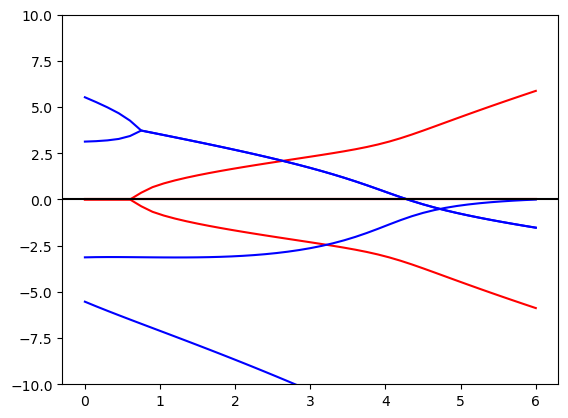

In [416]:
bike=Bike()
velocity=np.linspace(0,6,41)
output=[]
for v in velocity:
    matrix,_=bike.LinearMatrix(v)
    output.append(np.linalg.eig(matrix)[0])
realPart,imagPart=SortEigenValues(output)
plt.plot(velocity,imagPart[:,0],'r')
plt.plot(velocity,imagPart[:,1],'r')
plt.plot(velocity,imagPart[:,2],'r')
plt.plot(velocity,imagPart[:,3],'r')
plt.plot(velocity,realPart[:,0],'b')
plt.plot(velocity,realPart[:,1],'b')
plt.plot(velocity,realPart[:,2],'b')
plt.plot(velocity,realPart[:,3],'b')
plt.axhline(0,color='k')
plt.ylim((-10,10))
# plt.ylim((-5,5))
plt.show()

In [546]:
# state = phi, delta, phidot, deltadot
KrVLow=1
velocity=np.linspace(KrVLow,6,41)
Krs=[]
eigs=[]
for v in velocity:
    A,B=bike.LinearMatrix(v)
    QW=np.diag([1,1,1,50])
    RW=10
    Kr, _, _ = ct.lqr(A,B,QW,RW)
    Krs.append(Kr.flatten().copy())
    eigValue=np.linalg.eig(A-B@Kr)[0]
    eigs.append(np.linalg.eig(A-B@Kr)[0])
Krs=np.array(Krs)
eigs=np.array(eigs)

In [547]:
# state = phi, delta, phidot, deltadot
Kr0=FitPolynomial(Krs[:,0],velocity,return_data=True)
Kr1=FitPolynomial(Krs[:,1],velocity,return_data=True)
Kr2=FitPolynomial(Krs[:,2],velocity,return_data=True)
Kr3=FitPolynomial(Krs[:,3],velocity,return_data=True)
KrFit=np.hstack((Kr0,Kr1,Kr2,Kr3))
g=9.81
eigsFit=[]
for i in range(velocity.shape[0]):
    v=velocity[i]
    A,B=bike.LinearMatrix(v)
    Kr=np.expand_dims(KrFit[i],0)
    eigsFit.append(np.linalg.eig(A-B@Kr)[0])
eigsFit=np.array(eigsFit)

error=  0.015839808071184378
error=  0.034314806220494716
error=  0.0024715146724564527
error=  0.0001883855068143301


In [548]:
# state = phi, delta, phidot, deltadot
Kr0=FitPolynomial(Krs[:,0],velocity,return_data=True)
Kr1=FitPolynomial(Krs[:,1],velocity,return_data=True)
Kr2=FitPolynomial(Krs[:,2],velocity,return_data=True)
Kr3=FitPolynomial(Krs[:,3],velocity,return_data=True)
KrFit=np.hstack((Kr0,Kr1,Kr2,Kr3))
g=9.81
eigsFit=[]
for i in range(velocity.shape[0]):
    v=velocity[i]
    A,B=bike.LinearMatrix(v)
    Kr=np.expand_dims(KrFit[i],0)
    eigsFit.append(np.linalg.eig(A-B@Kr)[0])
eigsFit=np.array(eigsFit)

error=  0.015839808071184378
error=  0.034314806220494716
error=  0.0024715146724564527
error=  0.0001883855068143301


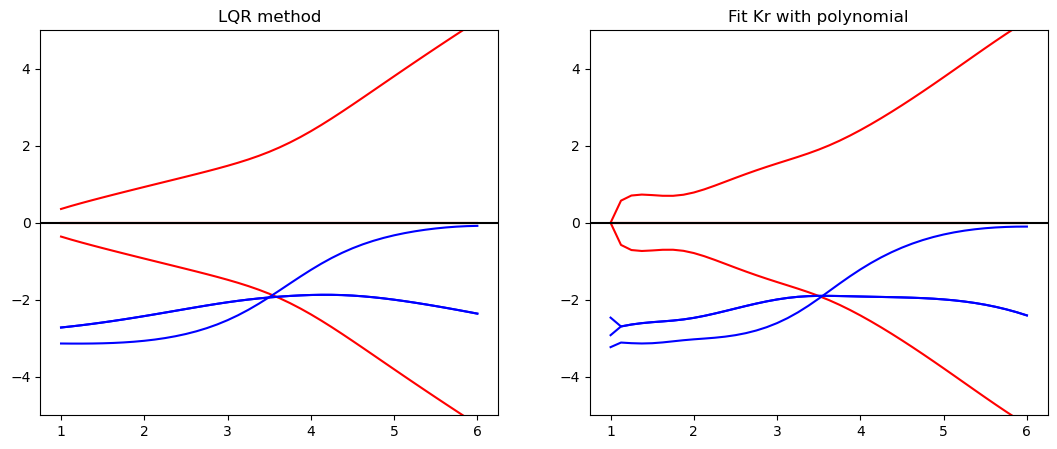

In [549]:
fig, axs = plt.subplots(1,2,figsize=(13,5))
realPart,imagPart=SortEigenValues(eigs)
axs[0].plot(velocity,imagPart[:,0],'r')
axs[0].plot(velocity,imagPart[:,1],'r')
axs[0].plot(velocity,imagPart[:,2],'r')
axs[0].plot(velocity,imagPart[:,3],'r')
axs[0].plot(velocity,realPart[:,0],'b')
axs[0].plot(velocity,realPart[:,1],'b')
axs[0].plot(velocity,realPart[:,2],'b')
axs[0].plot(velocity,realPart[:,3],'b')
axs[0].axhline(0,color='k')
axs[0].set_ylim([-5, 5])
axs[0].set_title("LQR method")
realPart,imagPart=SortEigenValues(eigsFit)
axs[1].plot(velocity,imagPart[:,0],'r')
axs[1].plot(velocity,imagPart[:,1],'r')
axs[1].plot(velocity,imagPart[:,2],'r')
axs[1].plot(velocity,imagPart[:,3],'r')
axs[1].plot(velocity,realPart[:,0],'b')
axs[1].plot(velocity,realPart[:,1],'b')
axs[1].plot(velocity,realPart[:,2],'b')
axs[1].plot(velocity,realPart[:,3],'b')
axs[1].axhline(0,color='k')
axs[1].set_ylim([-5, 5])
axs[1].set_title("Fit Kr with polynomial")
plt.show()

In [550]:
beta0=FitPolynomial(Krs[:,0],velocity,quiet=True)
print('beta0= ',beta0.flatten())
beta1=FitPolynomial(Krs[:,1],velocity,quiet=True)
print('beta1= ',beta1.flatten())
beta2=FitPolynomial(Krs[:,2],velocity,quiet=True)
print('beta2= ',beta2.flatten())
beta3=FitPolynomial(Krs[:,3],velocity,quiet=True)
print('beta3= ',beta3.flatten())
beta=np.hstack((beta0,beta1,beta2,beta3))

beta0=  [  -0.0304591   -0.2748146    1.1936591   33.1917237 -150.3649392
  -54.8137286]
beta1=  [ 0.6795316 -8.1982699 27.1333959 -5.9230184 -3.6886547  1.0969404]
beta2=  [  0.1365443  -2.3202595  12.0937428 -14.0415125 -24.0240539 -26.4651558]
beta3=  [ 0.0241403 -0.1586925 -0.7748011  6.7422284 -4.1943132  0.9137269]


In [596]:
# state = phi, delta, phidot, deltadot
phi0,delta0=-0./180*pi,10/180*pi
x=np.array([[phi0],[delta0],[0.0],[0]])
v=0.01
acc=1
psidotRef=0.0/30*pi

psidot=bike.lmd/bike.w*(v*x[1]+bike.c*x[3])
output=[]
output.append([x[0],x[1],psidot])

interval=1/50
for i in range(int(10/interval)):
    A,B=bike.LinearMatrix(v)
    vPoly=np.array([[v**3,v**2,v,1,1/max(KrVLow,v),1/max(KrVLow,v)**2]])
    Kr=vPoly@beta
    x=(np.identity(4)+(A-B@Kr)*interval)@x+interval*B/(np.array([[0,-bike.lmd/bike.w*v,0,0]])@inv(A-B@Kr)@B)[0,0]*psidotRef
    psidot=bike.lmd/bike.w*(v*x[1]+bike.c*x[3])
    output.append([x[0],x[1],psidot])
    v+=acc*interval
    v=np.clip(v,0,1)
output=np.squeeze(np.array(output))

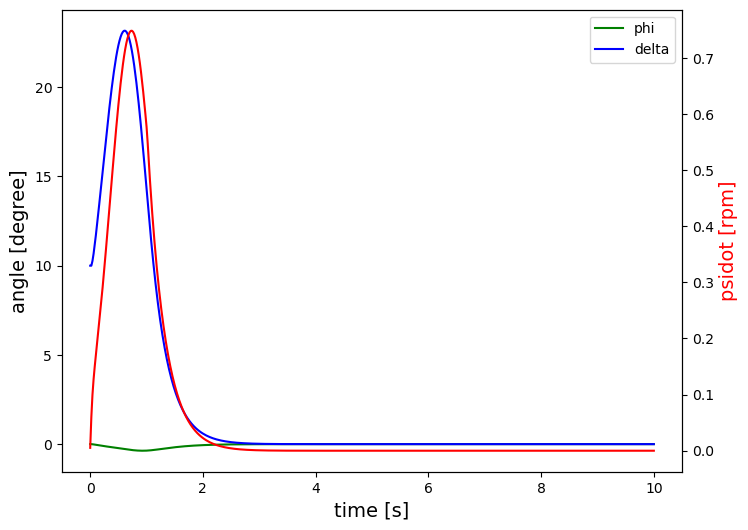

In [597]:
timeAxis=np.linspace(0,10,int(10/interval)+1)
plt.figure(figsize=(8,6))
plt.plot(timeAxis,output[:,0]*180/pi,'g',label="phi")
plt.plot(timeAxis,output[:,1]*180/pi,'b',label="delta")
plt.legend(loc="upper right")
plt.xlabel('time [s]', fontsize=14)
plt.ylabel('angle [degree]',fontsize=14)
rightax=plt.twinx()
rightax.plot(timeAxis,output[:,2]*30/pi,'r')
rightax.set_ylabel('psidot [rpm]',fontsize=14)
rightax.yaxis.label.set_color('red')
# rightax.axhline(psidotRef*30/pi,color='k')
plt.show()

Track stand

In [612]:
bike=Bike()
delta0=0/180*pi
delta1=50/180*pi
phi0=bike.FindPhiToBalance(delta0)
thetaB0,thetaU0=bike.FindThetaBThetaU(phi0,delta0)
dir0=bike.dUdthetaU(phi0,thetaB0,delta0,thetaU0)
ratio0=dir0[1,0]/dir0[0,0]
phi1=bike.FindPhiToBalance(delta1)
thetaB1,thetaU1=bike.FindThetaBThetaU(phi1,delta1)
dir1=bike.dUdthetaU(phi1,thetaB1,delta1,thetaU1)
ratio1=dir1[1,0]/dir1[0,0]
for _ in range(20):
    delta2=(delta0+delta1)/2    
    phi2=bike.FindPhiToBalance(delta2)
    thetaB2,thetaU2=bike.FindThetaBThetaU(phi2,delta2)
    dir2=bike.dUdthetaU(phi2,thetaB2,delta2,thetaU2)
    ratio2=dir2[1,0]/dir2[0,0]
    if (ratio2-1)*(ratio0-1)<0:
        delta1=delta2
        ratio1=ratio2
    else:
        delta0=delta2
        ratio0=ratio2
phi=phi2
delta=delta2
print(phi/pi*180,delta/pi*180)
print(dir2)

23.50824542809278 40.49191474914552
[[ 0.2474875]
 [ 0.2474872]
 [-0.       ]]


In [613]:
A,B=bike.LinearMatrixVar(phi,delta)
QW=np.diag([1,1,10,1,1])
RW=np.diag([0.1,0.1])
Kr, _, _ = ct.lqr(A,B,QW,RW)
print(Kr)
print(np.linalg.eig(A-B@Kr)[0])

[[ -55.3267808   -1.7814678    9.9907201  -51.7982652   -1.1124202]
 [-204.4559095    2.8380803    0.430712  -210.266941    -2.87028  ]]
[-5.7866657+0.j        -1.0596103+0.9938694j -1.0596103-0.9938694j
 -1.0319009+0.j        -1.0479711+0.j       ]


In [614]:
# state = phi, delta,thetaRdot, phidot, deltadot
x=np.array([[0.01],[0.],[0],[0],[0]])
output=[]
output.append(x)

timeLength=10
interval=1/50
timeAxis=np.linspace(0,timeLength,int(timeLength/interval)+1)
for i in range(int(timeLength/interval)):
    x=(np.identity(5)+(A-B@Kr)*interval)@x
    output.append(x)
output=np.squeeze(np.array(output))

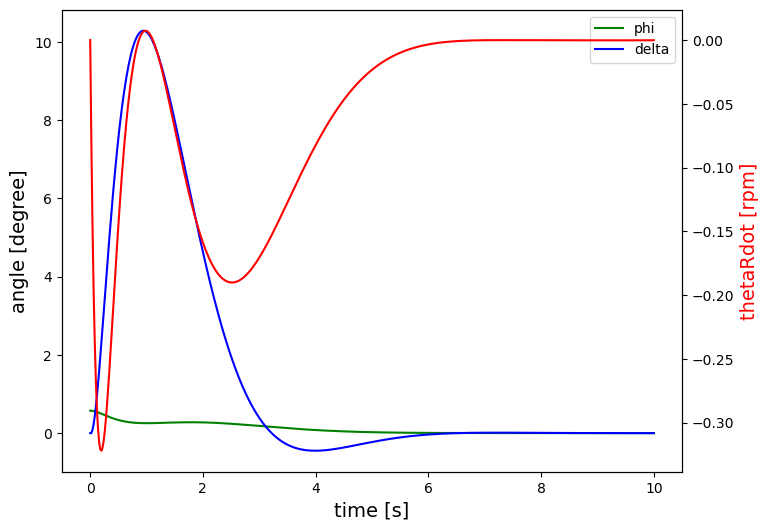

In [615]:
plt.figure(figsize=(8,6))
plt.plot(timeAxis,output[:,0]*180/pi,'g',label="phi")
plt.plot(timeAxis,output[:,1]*180/pi,'b',label="delta")
plt.legend(loc="upper right")
plt.xlabel('time [s]', fontsize=14)
plt.ylabel('angle [degree]',fontsize=14)
rightax=plt.twinx()
rightax.plot(timeAxis,output[:,2]*30/pi,'r')
rightax.set_ylabel('thetaRdot [rpm]',fontsize=14)
rightax.yaxis.label.set_color('red')
plt.show()

Bike when lambda=0 and c=0

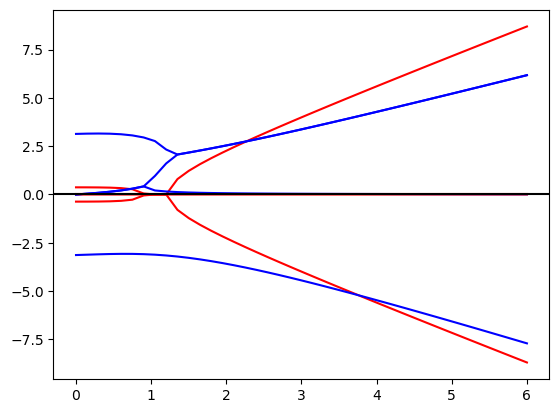

In [10]:
bike=Bike(lmd=0,c=0)
velocity=np.linspace(0,6,41)
output=[]
for v in velocity:
    matrix,_=bike.LinearMatrix(v)
    output.append(np.linalg.eig(matrix)[0])
realPart,imagPart=SortEigenValues(output)
plt.plot(velocity,imagPart[:,0],'r')
plt.plot(velocity,imagPart[:,1],'r')
plt.plot(velocity,imagPart[:,2],'r')
plt.plot(velocity,imagPart[:,3],'r')
plt.plot(velocity,realPart[:,0],'b')
plt.plot(velocity,realPart[:,1],'b')
plt.plot(velocity,realPart[:,2],'b')
plt.plot(velocity,realPart[:,3],'b')
plt.axhline(0,color='k')
# plt.ylim((-10,10))
# plt.ylim((-5,5))
plt.show()

In [11]:
# state = phi, delta, phidot, deltadot
velocity=np.linspace(1,6,21)
Krs=[]
eigs=[]
for v in velocity:
    A,B=bike.LinearMatrix(v)
    QW=np.diag([1,1,1,50])
    RW=10
    Kr, _, _ = ct.lqr(A,B,QW,RW)
    Krs.append(Kr.flatten().copy())
    eigValue=np.linalg.eig(A-B@Kr)[0]
    eigs.append(np.linalg.eig(A-B@Kr)[0])
Krs=np.array(Krs)
eigs=np.array(eigs)

In [12]:
# state = phi, delta, phidot, deltadot
Kr0=FitPolynomial(Krs[:,0],velocity,return_data=True)
Kr1=FitPolynomial(Krs[:,1],velocity,return_data=True)
Kr2=FitPolynomial(Krs[:,2],velocity,return_data=True)
Kr3=FitPolynomial(Krs[:,3],velocity,return_data=True)
KrFit=np.hstack((Kr0,Kr1,Kr2,Kr3))
g=9.81
eigsFit=[]
for i in range(velocity.shape[0]):
    v=velocity[i]
    A,B=bike.LinearMatrix(v)
    Kr=np.expand_dims(KrFit[i],0)
    eigsFit.append(np.linalg.eig(A-B@Kr)[0])
eigsFit=np.array(eigsFit)

error=  0.0001360986716748173
error=  7.670953446433293e-05
error=  4.8416221489464734e-05
error=  1.7843545262473523e-06


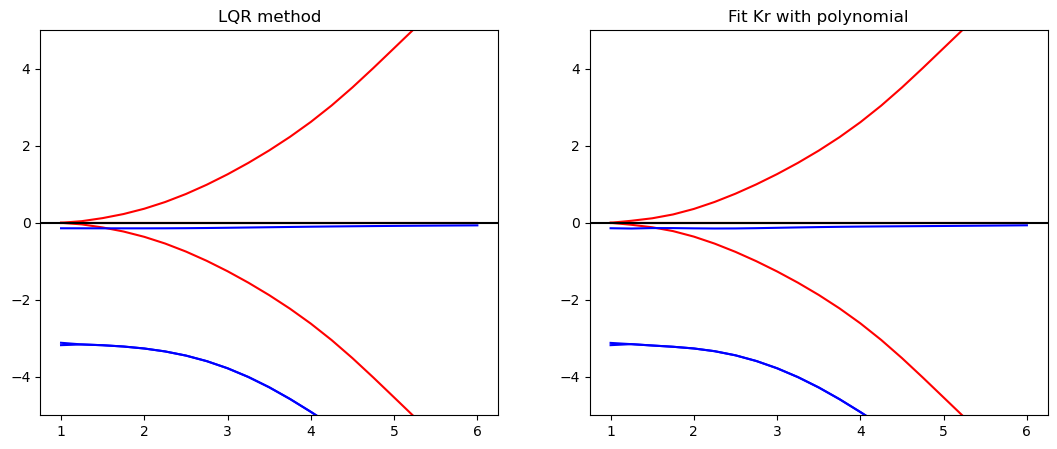

In [13]:
fig, axs = plt.subplots(1,2,figsize=(13,5))
realPart,imagPart=SortEigenValues(eigs)
axs[0].plot(velocity,imagPart[:,0],'r')
axs[0].plot(velocity,imagPart[:,1],'r')
axs[0].plot(velocity,imagPart[:,2],'r')
axs[0].plot(velocity,imagPart[:,3],'r')
axs[0].plot(velocity,realPart[:,0],'b')
axs[0].plot(velocity,realPart[:,1],'b')
axs[0].plot(velocity,realPart[:,2],'b')
axs[0].plot(velocity,realPart[:,3],'b')
axs[0].axhline(0,color='k')
axs[0].set_ylim([-5, 5])
axs[0].set_title("LQR method")
realPart,imagPart=SortEigenValues(eigsFit)
axs[1].plot(velocity,imagPart[:,0],'r')
axs[1].plot(velocity,imagPart[:,1],'r')
axs[1].plot(velocity,imagPart[:,2],'r')
axs[1].plot(velocity,imagPart[:,3],'r')
axs[1].plot(velocity,realPart[:,0],'b')
axs[1].plot(velocity,realPart[:,1],'b')
axs[1].plot(velocity,realPart[:,2],'b')
axs[1].plot(velocity,realPart[:,3],'b')
axs[1].axhline(0,color='k')
axs[1].set_ylim([-5, 5])
axs[1].set_title("Fit Kr with polynomial")
plt.show()

Penny farthing

In [14]:
bike=Bike(
    w=0.9,
    c=0,
    lmd=0,
    rR=0.2,
    mR=1.5,
    IRxx=0.03,
    IRyy=0.06,
    xB=0.5,
    zB=-0.8,
    mB=5,
    IBxx=0.35,
    IBxz=0.15,
    IBzz=0.35,
    IByy=0.7,
    xH=0.9,
    zH=-1.3,
    mH=2,
    IHxx=0.35,
    IHxz=0,
    IHzz=0,
    IHyy=0.35,
    rF=0.7,
    mF=6,
    IFxx=1.41,
    IFyy=2.82
)

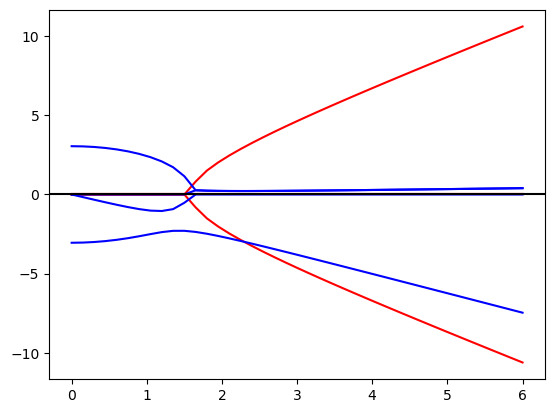

In [15]:
velocity=np.linspace(0,6,41)
eigsWithoutFeedBack=[]
for v in velocity:
    matrix,_=bike.LinearMatrix(v)
    eigsWithoutFeedBack.append(np.linalg.eig(matrix)[0])
realPart,imagPart=SortEigenValues(eigsWithoutFeedBack)
plt.plot(velocity,imagPart[:,0],'r')
plt.plot(velocity,imagPart[:,1],'r')
plt.plot(velocity,imagPart[:,2],'r')
plt.plot(velocity,imagPart[:,3],'r')
plt.plot(velocity,realPart[:,0],'b')
plt.plot(velocity,realPart[:,1],'b')
plt.plot(velocity,realPart[:,2],'b')
plt.plot(velocity,realPart[:,3],'b')
plt.axhline(0,color='k')
# plt.ylim((-2,2))
plt.show()

In [16]:
# state = phi, delta, phidot, deltadot
velocity=np.linspace(2,7,21)
Krs=[]
eigs=[]
for v in velocity:
    A,B=bike.LinearMatrix(v)
    QW=np.diag([1,1,1,50])
    RW=10
    Kr, _, _ = ct.lqr(A,B,QW,RW)
    Krs.append(Kr.flatten().copy())
    eigValue=np.linalg.eig(A-B@Kr)[0]
    eigs.append(np.linalg.eig(A-B@Kr)[0])
Krs=np.array(Krs)
eigs=np.array(eigs)

In [17]:
# state = phi, delta, phidot, deltadot
Kr0=FitPolynomial(Krs[:,0],velocity,return_data=True)
Kr1=FitPolynomial(Krs[:,1],velocity,return_data=True)
Kr2=FitPolynomial(Krs[:,2],velocity,return_data=True)
Kr3=FitPolynomial(Krs[:,3],velocity,return_data=True)
KrFit=np.hstack((Kr0,Kr1,Kr2,Kr3))
g=9.81
eigsFit=[]
for i in range(velocity.shape[0]):
    v=velocity[i]
    A,B=bike.LinearMatrix(v)
    Kr=np.expand_dims(KrFit[i],0)
    eigsFit.append(np.linalg.eig(A-B@Kr)[0])
eigsFit=np.array(eigsFit)

error=  8.552862127360777e-05
error=  1.8817522295148316e-05
error=  5.403188273874412e-05
error=  6.144559747694901e-07


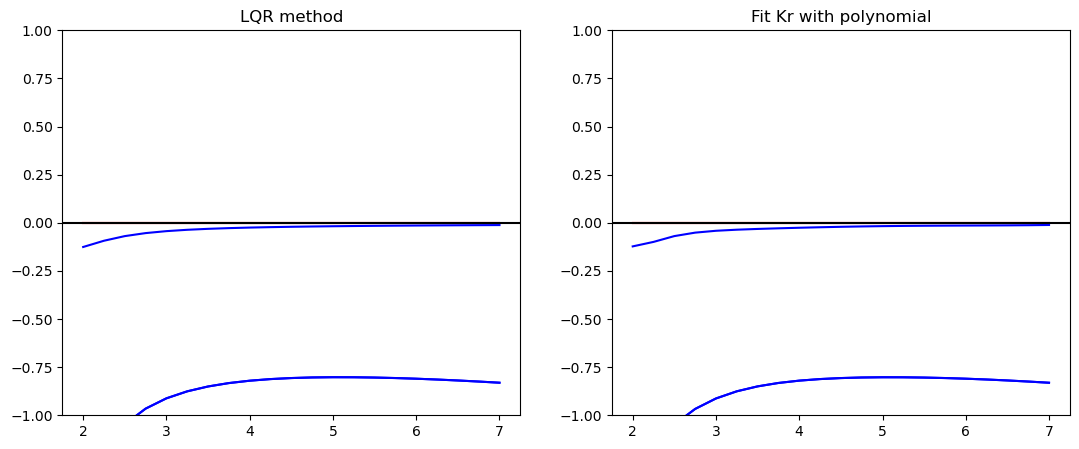

In [18]:
fig, axs = plt.subplots(1,2,figsize=(13,5))
realPart,imagPart=SortEigenValues(eigs)
axs[0].plot(velocity,imagPart[:,0],'r')
axs[0].plot(velocity,imagPart[:,1],'r')
axs[0].plot(velocity,imagPart[:,2],'r')
axs[0].plot(velocity,imagPart[:,3],'r')
axs[0].plot(velocity,realPart[:,0],'b')
axs[0].plot(velocity,realPart[:,1],'b')
axs[0].plot(velocity,realPart[:,2],'b')
axs[0].plot(velocity,realPart[:,3],'b')
axs[0].axhline(0,color='k')
axs[0].set_ylim([-1, 1])
axs[0].set_title("LQR method")
realPart,imagPart=SortEigenValues(eigsFit)
axs[1].plot(velocity,imagPart[:,0],'r')
axs[1].plot(velocity,imagPart[:,1],'r')
axs[1].plot(velocity,imagPart[:,2],'r')
axs[1].plot(velocity,imagPart[:,3],'r')
axs[1].plot(velocity,realPart[:,0],'b')
axs[1].plot(velocity,realPart[:,1],'b')
axs[1].plot(velocity,realPart[:,2],'b')
axs[1].plot(velocity,realPart[:,3],'b')
axs[1].axhline(0,color='k')
axs[1].set_ylim([-1, 1])
axs[1].set_title("Fit Kr with polynomial")
plt.show()

# Wheel

In [19]:
g=9.81
rR=0.3
m=2
Ixz=0.0603
Iy=0.12
btheta=0.01
bpsi=0.01
bphi=0.01
btheta=bpsi=bphi=0

theta0,psi0,phi0=0,0,15/180*pi
thetadot0,psidot0,phidot0=-2*pi/0.5,24.137/180*pi,0
interval=0.0001
timeLength=4
timeVector=np.linspace(0,timeLength,int(timeLength/interval+1))
x=np.array([[theta0],[psi0],[phi0]])
xdot=np.array([[thetadot0],[psidot0],[phidot0]])
output=[]
output.append(np.vstack((x,xdot)))
energy=[]
theta,psi,phi=x.flatten()
thetadot,psidot,phidot=xdot.flatten()
KE=1/2*m*rR**2*(thetadot**2+sin(phi)**2*psidot**2+phidot**2+2*sin(phi)*thetadot*psidot)+1/2*Iy*(thetadot+psidot*sin(phi))**2+1/2*Ixz*(phidot**2+psidot**2*cos(phi)**2)
PE=m*g*rR*cos(phi)
energy.append(KE+PE)
for i in range(int(timeLength/interval)):
    theta,psi,phi=x.flatten()
    thetadot,psidot,phidot=xdot.flatten()
    M=np.array([
        [m*rR**2+Iy,m*rR**2*sin(phi)+Iy*sin(phi),0],
        [m*rR**2*sin(phi)+Iy*sin(phi),m*rR**2*sin(phi)**2+Iy*sin(phi)**2+Ixz*cos(phi)**2,0],
        [0,0,m*rR**2+Ixz]
    ])
    A=np.array([
        [(2*m*rR**2+Iy)*cos(phi)*psidot*phidot+btheta*thetadot],
        [(m*rR**2+Iy-Ixz)*sin(2*phi)*psidot*phidot+Iy*cos(phi)*thetadot*phidot+bpsi*psidot],
        [-(m*rR**2+Iy-Ixz)*sin(phi)*cos(phi)*psidot**2-(m*rR**2+Iy)*cos(phi)*thetadot*psidot-m*g*rR*sin(phi)+bphi*phidot],
    ])
    xdot2=-inv(M)@A
    x=x+xdot*interval
    xdot=xdot+xdot2*interval
    output.append(np.vstack((x,xdot)))
    KE=1/2*m*rR**2*(thetadot**2+sin(phi)**2*psidot**2+phidot**2+2*sin(phi)*thetadot*psidot)+1/2*Iy*(thetadot+psidot*sin(phi))**2+1/2*Ixz*(phidot**2+psidot**2*cos(phi)**2)
    PE=m*g*rR*cos(phi)
    energy.append(KE+PE)
output=np.array(output).reshape((-1,6))
theta,psi,phi,thetadot,psidot,phidot=output.T
energy=np.array(energy)

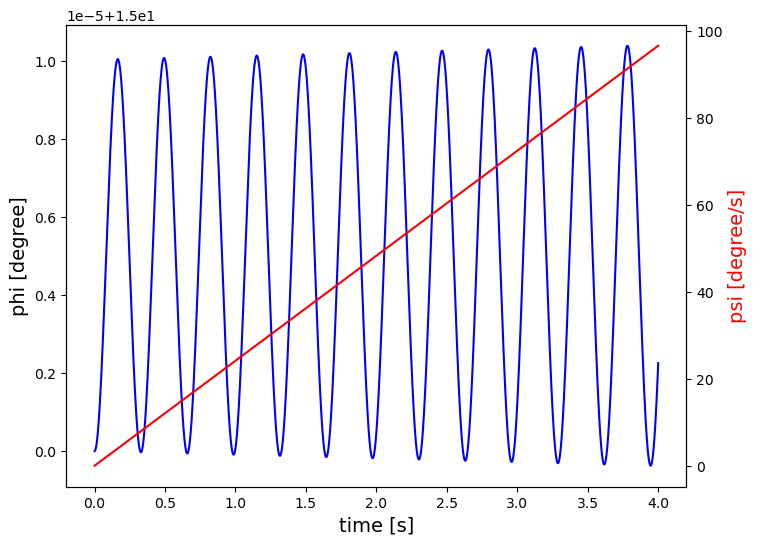

In [20]:
plt.figure(figsize=(8,6))
plt.plot(timeVector,phi*180/pi, 'b')
plt.xlabel('time [s]', fontsize=14)
plt.ylabel('phi [degree]',fontsize=14)
rightax=plt.twinx()
rightax.plot(timeVector,psi*180/pi, 'r')
rightax.set_ylabel('psi [degree/s]',fontsize=14)
# rightax.plot(timeVector,psidot*180/pi, 'r')
# rightax.set_ylabel('psidot [degree/s]',fontsize=14)
# rightax.plot(timeVector,energy, 'r')
# rightax.set_ylabel('energy [J]',fontsize=14)
rightax.yaxis.label.set_color('red')
plt.show()

In [21]:
g=9.81
rR=r=0.3
m=2
Ixz=It=0.0603
Iy=Ia=0.12
btheta=0.01
bpsi=0.01
bphi=0.01
btheta=bpsi=bphi=0

interval=0.0001
timeLength=4
timeVector=np.linspace(0,timeLength,int(timeLength/interval+1))
x=np.array([[-psi0],[phi0+pi/2],[theta0]])
xdot=np.array([[-psidot0],[phidot0],[thetadot0]])
psi,theta,phi=x.flatten()
output=[]
output.append(np.array([phi,-psi,theta-pi/2]))
energy=[]
psi,theta,phi=x.flatten()
psidot,thetadot,phidot=xdot.flatten()
KE=1/2*Iy*(psidot*cos(theta)+phidot)**2+1/2*Ixz*(psidot**2*sin(theta)**2+thetadot**2)+1/2*m*r**2*(phidot**2+thetadot**2+cos(theta)**2*psidot**2+2*cos(theta)*phidot*psidot)
PE=m*g*rR*sin(theta)
energy.append(KE+PE)
Ptheta=[]
Pphi=[]
Ptheta.append((It+m*r**2)*thetadot)
Pphi.append(Ia*(psidot*cos(theta)+phidot)+m*r**2*phidot+m*r**2*cos(theta)*psidot)
for i in range(int(timeLength/interval)):
    psi,theta,phi=x.flatten()
    psidot,thetadot,phidot=xdot.flatten()
    M=np.array([
        [(Ia+m*r**2)*cos(theta)**2+It*sin(theta)**2,0,(Ia+m*r**2)*cos(theta)],
        [0,It+m*r**2,0],
        [(Ia+m*r**2)*cos(theta),0,Ia+m*r**2]
    ])
    f=np.array([
        [(Ia-It+m*r**2)*2*sin(theta)*cos(theta)*psidot*thetadot+Ia*sin(theta)*thetadot*phidot],
        [-(Ia-It+m*r**2)*sin(theta)*cos(theta)*psidot**2-(Ia+m*r**2)*sin(theta)*psidot*phidot-m*g*r*cos(theta)],
        [(Ia+2*m*r**2)*sin(theta)*psidot*thetadot],
    ])
    xdot2=inv(M)@f
    x=x+xdot*interval
    xdot=xdot+xdot2*interval
    output.append(np.array([phi%(2*pi),-psi%(2*pi),(theta-pi/2)%(2*pi)]))
    KE=1/2*Iy*(psidot*cos(theta)+phidot)**2+1/2*Ixz*(psidot**2*sin(theta)**2+thetadot**2)+1/2*m*r**2*(phidot**2+thetadot**2+cos(theta)**2*psidot**2+2*cos(theta)*phidot*psidot)
    PE=m*g*rR*sin(theta)
    energy.append(KE+PE)
    Ptheta.append((It+m*r**2)*thetadot)
    Pphi.append(Ia*(psidot*cos(theta)+phidot)+m*r**2*phidot+m*r**2*cos(theta)*psidot)
output=np.array(output).reshape((-1,3))
theta,psi,phi=output.T
energy=np.array(energy)
Ptheta=np.array(Ptheta)
Pphi=np.array(Pphi)

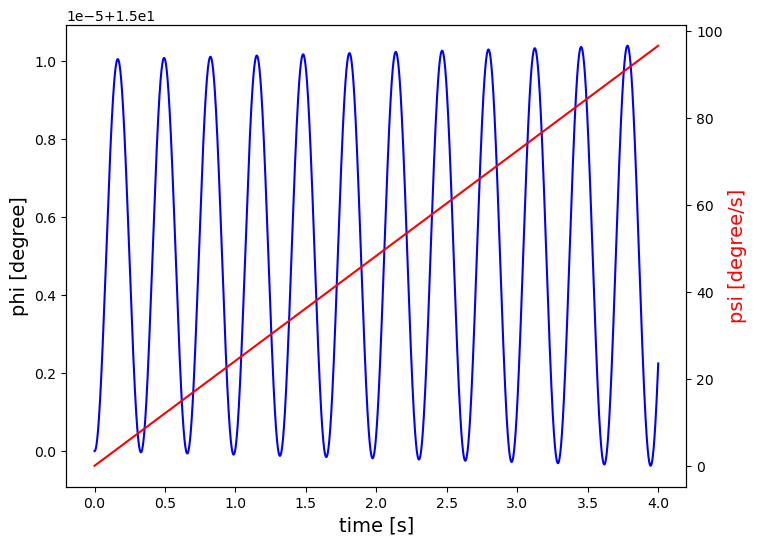

In [22]:
plt.figure(figsize=(8,6))
plt.plot(timeVector,phi*180/pi, 'b')
plt.xlabel('time [s]', fontsize=14)
plt.ylabel('phi [degree]',fontsize=14)
rightax=plt.twinx()
rightax.plot(timeVector,psi*180/pi, 'r')
rightax.set_ylabel('psi [degree/s]',fontsize=14)
# rightax.plot(timeVector,psidot*180/pi, 'r')
# rightax.set_ylabel('psidot [degree/s]',fontsize=14)
# rightax.plot(timeVector,energy, 'r')
# rightax.set_ylabel('energy [J]',fontsize=14)
# rightax.plot(timeVector,Ptheta, 'r')
# rightax.set_ylabel('Ptheta [J*s]',fontsize=14)
# rightax.plot(timeVector,Pphi, 'r')
# rightax.set_ylabel('Pphi [J*s]',fontsize=14)
rightax.yaxis.label.set_color('red')
plt.show()